In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        # 입력 채널 1 -> 흑백 이미지
        # 출력 채널 16 -> 설계자의 임의 결정
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # 커널 사이즈 2 -> 보편적인 사이즈 2x2

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # 입력 채널 16 -> 상기 합성층의 출력 채널 수
        # 출력 채널 32 -> 설계자의 임의 결정
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.fc = nn.Linear(32 * 7 * 7, 10)
        # 32 -> 상기 합성층의 출력 채널 수
        # 7 * 7 -> 상기 풀링을 거친 특징값 행렬의 크기

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Epoch 1 / 10, Loss : 0.2417
Epoch 2 / 10, Loss : 0.0687


KeyboardInterrupt: 

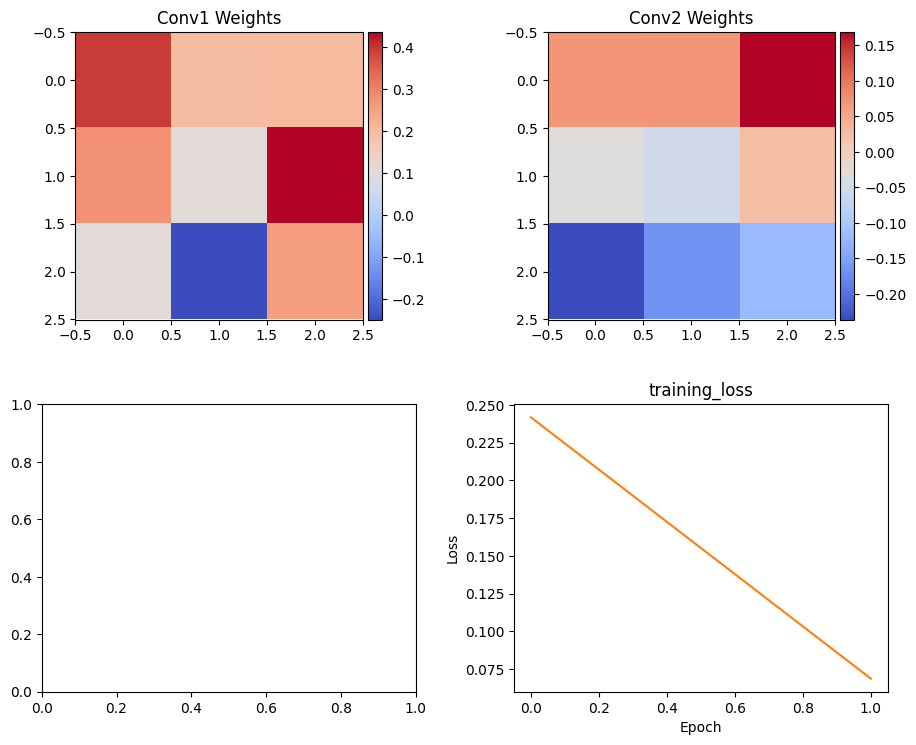

In [3]:
if __name__ == "__main__":
    train_dataset = MNIST('./train', train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = MNIST('./train', train=False, transform=transforms.ToTensor())
    # train_dataset이 만들어지면서 download=True 옵션 때문에 지정한 ./train 경로에 다운로드됨
    # test_dataset은 상기 경로에 다운로드된 데이터 중 t10k로 시작하는 데이터를 train=False 옵션으로 사용하게 됨
    # transform은 현재 텐서화 이외에는 적용하지 않음

    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    # train 데이터로더는 shuffle 옵션을 True로 지정
    # test 데이터로더는 shuffle 옵션이 필요 없음

    model = CNN().to(device)
    # 모델을 적절한 장치에 넘김

    criterion = nn.CrossEntropyLoss()
    # 다중 클래스 분류 문제이므로, Cross Entropy 손실 함수 사용
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # lr 초기값은 설계자의 임의 지정

    num_epochs = 10

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    fig.tight_layout(pad=4.0)
    axs = axs.flatten()
    # 시각화를 위한 그리드 설정

    epoch_losses = []
    # 오차 강하 그래프를 그리기 위한 오차를 담을 list

    for epoch in range(num_epochs):
        model.train()
        # 모델을 학습 모드로 설정
        running_loss = 0.0
        # 트레인 로더를 한번 순회한 오차값

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            # loader에서 받아온 image와 label을 적절한 장치에 넘김

            optimizer.zero_grad() # 그래디언트 초기화

            outputs = model(images)
            # 모델에 받아온 images를 입력 후 예측값인 outputs를 받아옴

            loss = criterion(outputs, labels)
            # 실제 정답인 labels와 상기 예측값인 outputs를 손실함수로 대조하여 오차 출력

            loss.backward()
            optimizer.step()
            # 역전파 이후 optimizer가 가중치 업데이트

            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_dataset)
        epoch_losses.append(epoch_loss)
        # epoch 순회마다 발생한 loss를 리스트에 추가

        print(f"Epoch {epoch+1} / {num_epochs}, Loss : {epoch_loss:.4f}")
        # Epoch 순회마다 발생한 loss 출력

        if epoch == 0:
            weights = model.conv1.weight.detach().cpu().numpy()
            axs[0].imshow(weights[0, 0], cmap='coolwarm')
            axs[0].set_title("Conv1 Weights")
            divider = make_axes_locatable(axs[0])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            plt.colorbar(axs[0].imshow(weights[0, 0], cmap='coolwarm'), cax=cax)
            # 첫번째 합성곱 레이어의 가중치 시각화

            weights = model.conv2.weight.detach().cpu().numpy()
            axs[1].imshow(weights[0, 0], cmap='coolwarm')
            axs[1].set_title("Conv2 Weights")
            divider = make_axes_locatable(axs[1])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            plt.colorbar(axs[1].imshow(weights[0, 0], cmap='coolwarm'), cax=cax)
            # 두번째 합성곱 레이어의 가중치 시각화

        axs[3].plot(range(epoch+1), epoch_losses)
        axs[3].set_title('training_loss')
        axs[3].set_xlabel('Epoch')
        axs[3].set_ylabel('Loss')
        # epoch loss 그래프

    plt.show()


    # 이하 모델 평가 코드
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            # outputs가 10개의 확률함수로 나타나게 될 것
            # -> outputs에 나타난 10개 확률 중 가장 높은 값을 취함 -> 모델이 예측한 숫자
            temp, predicted = torch.max(outputs.data, 1)
            # 출력 튜플의 두번째 값 -> 모델이 예측한 라벨
            print(f"temp is following value : {temp}")

            total += labels.size(0)
            # 이번 test loader에 올라온 label의 숫자를 총 숫자에 합산함
            correct += (predicted == labels).sum().item()
            # predicted와 labels 둘 다 일정 갯수의 행렬 형태로 나올 것
            # (predicted == labels) -> 같은 값은 행렬 내에서 1, 아니면 0 -> ex) [1. , 0. , 1. , 1. , ...]
            # 위에서 얻은 1, 0, 으로 이루어진 행렬의 합을 구함 -> sum()

    accuracy = (correct / total) * 100
    print(f"Test Accuracy: {accuracy:.2f} %")